# Separating GLORYs Bottom and Surface Temperature

This notebook will read in the collection of GLORYs files, create an index for bottom and surface observations, extract bottom and surface temperatures (or other variables if edited from `theato`), and finally save the extracted values as new files for additional use.

In [1]:

####  Libraries  ####
import xarray as xr
import dask
import os
import numpy as np

# Paths to resources
UsrName = "adamkemberling"
box_path = f"/Users/{UsrName}/Library/CloudStorage/Box-Box/"

# Project Paths
gpath = f"{box_path}RES_Data/GLORYs/NW_Atl_MonthlyTemps/"

# Monthly Temperatures Only
glorys_file = f"{box_path}RES_Data/GLORYs/NW_Atl_MonthlyTemps/NW_Atl_MonthlyTemps_FullTS.nc" # on box

### Pull the indices for deepest and surface layers

For this step we only need one file open since the depth is unchanging across files.

In [2]:
# Open one file to get depth indices

# glorys_single = xr.open_mfdataset(f"{glorys_path}{fpaths_glorys[0]}", combine = "by_coords", parallel = True, engine = 'h5netcdf')
# glorys_single = xr.open_mfdataset(f"{glorys_file}", combine = "by_coords", parallel = True, engine = 'h5netcdf')

# New files with temperature and salinity
glorys_tempsalfiles = [
    f"{gpath}NW_Atl_MonthlyTempSal_1993to2000.nc",
    f"{gpath}NW_Atl_MonthlyTempSal_2000tomid2021.nc",
    f"{gpath}NW_Atl_MonthlyTempSal_mid2021to2024.nc"
]

# Open the first one
glorys_single = xr.open_mfdataset(glorys_tempsalfiles[0], combine = "by_coords", parallel = True)
glorys_single

<xarray.Dataset> Size: 2GB
Dimensions:    (depth: 38, latitude: 154, longitude: 235, time: 84)
Coordinates:
  * depth      (depth) float32 152B 0.494 1.541 2.646 ... 1.245e+03 1.452e+03
  * latitude   (latitude) float32 616B 35.25 35.33 35.42 ... 47.83 47.92 48.0
  * longitude  (longitude) float32 940B -75.75 -75.67 -75.58 ... -56.33 -56.25
  * time       (time) datetime64[ns] 672B 1993-01-01 1993-02-01 ... 1999-12-01
Data variables:
    thetao     (time, depth, latitude, longitude) float64 924MB dask.array<chunksize=(84, 38, 154, 235), meta=np.ndarray>
    so         (time, depth, latitude, longitude) float64 924MB dask.array<chunksize=(84, 38, 154, 235), meta=np.ndarray>
Attributes: (12/15)
    Conventions:                   CF-1.6
    area:                          GLOBAL
    contact:                       servicedesk.cmems@mercator-ocean.eu
    credit:                        E.U. Copernicus Marine Service Information...
    dataset:                       global-reanalysis-001-030-monthly
    institution:                   Mercator Ocean
    ...                            ...
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    references:                    http://marine.copernicus.eu
    source:                        MERCATOR GLORYS12V1
    title:                         Monthly mean fields for product GLOBAL_REA...
    copernicusmarine_version:      1.3.1

# Isolate Bottom and Surface Temperatures

The following function searches for the largest depth value that is non-NA. It then pulls that index number for each lat/lon location. This can then be used to pull values for other variables for those depths. After getting those indices, we then just manually change the depth index to 0 for all locations to coincide with a surface index.

In [3]:
# Identify Bottom Indices
# find bottom temp for any netcdf with depth
def find_deepest_depth_indices(ds, variable_id, y_coord, x_coord, depth_coord, maxDepth = 2000):


    # Subset up to an optional max depth
    kwargs = {depth_coord: slice(0, maxDepth)}
    false_bottom = ds.sel(**kwargs)

    # First get the vertical True/False of valid values
    idx = false_bottom[variable_id].isel(time=0).isnull()
    idx_vals = idx.values


    if len(false_bottom[variable_id][x_coord].dims) == 2:
        multiIndex = True
    else:
        multiIndex = False

    if multiIndex == True:
        dims0 = false_bottom[y_coord].dims[0]
        dims1 = false_bottom[y_coord].dims[1]
    else:
        dims0 = y_coord
        dims1 = x_coord


    # Create the initial final array to store indices (integer type)
    depth_indices = np.zeros((len(idx[y_coord][dims0]), len(idx[x_coord][dims1]))).astype(int)

    # Now find the deepest depth where values are True and store in indices array
    for i in range(len(false_bottom[dims1].values)):
        for j in range(len(false_bottom[dims0].values)):
            located = np.where(idx_vals[:, j, i] == False)
            try:
                depth_indices[j, i] = int(located[-1][-1])
            except IndexError:
                depth_indices[j, i] = 1

    # Gather as a DataArray
    ind = xr.DataArray(depth_indices, dims=[dims0, dims1])

    return ind

### Pull Bottom Indices

This step pulls the deepest, non-NA values up to a certain depth. For certain use-cases the max depth is important to note, and should be documented. For example, when bias correcting against another data product, bottom layers for off-shelf areas should be comparable.

The CMIP6 Data was downloaded with a max depth of 400 meters, so if we want off-shelf temperatures to be comparable we also need to limit depths to 400 meters here.

In [4]:
# What units of depth does it use?
glorys_single.depth.attrs

{'axis': 'Z',
 'long_name': 'Depth',
 'positive': 'down',
 'standard_name': 'depth',
 'unit_long': 'Meters',
 'units': 'm',
 'valid_max': 1452.251,
 'valid_min': 0.494025}

In [5]:
# Pull the bottom indices from the single glorys file
glorys_bottom_idx = find_deepest_depth_indices(
    ds = glorys_single, 
    variable_id = 'thetao', 
    x_coord     = 'longitude', 
    y_coord     = 'latitude', 
    depth_coord = 'depth', 
    #maxDepth    = 2000 # Actual Bottom
    maxDepth = 400 # Max depth from cmip downloads
    )
print(glorys_bottom_idx)

# Modify this slightly to have the index be [0] to eventually grab surface values
glorys_surface_idx = glorys_bottom_idx.copy()
glorys_surface_idx[:] = 0
print(glorys_surface_idx)

<xarray.DataArray (latitude: 154, longitude: 235)> Size: 290kB
array([[ 5,  6,  6, ..., 29, 29, 29],
       [ 5,  5,  5, ..., 29, 29, 29],
       [ 5,  5,  5, ..., 29, 29, 29],
       ...,
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ...,  1,  1,  1]])
Dimensions without coordinates: latitude, longitude
<xarray.DataArray (latitude: 154, longitude: 235)> Size: 290kB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Dimensions without coordinates: latitude, longitude


### Open the Full Collection

Now we can open the full GLORYS collection and pull values for the "bottom" layer and "surface" layer across the full time dimension.

In [6]:
# Temperature AND Salinity together from monthly files
# This is not working for some reason - because dates were overlapping, fixed that with new download
glorys_all = xr.open_mfdataset(
    glorys_tempsalfiles,
    combine = "by_coords")
glorys_all


<xarray.Dataset> Size: 8GB
Dimensions:    (time: 372, depth: 38, latitude: 154, longitude: 235)
Coordinates:
  * depth      (depth) float32 152B 0.494 1.541 2.646 ... 1.245e+03 1.452e+03
  * latitude   (latitude) float32 616B 35.25 35.33 35.42 ... 47.83 47.92 48.0
  * longitude  (longitude) float32 940B -75.75 -75.67 -75.58 ... -56.33 -56.25
  * time       (time) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2023-12-01
Data variables:
    thetao     (time, depth, latitude, longitude) float64 4GB dask.array<chunksize=(84, 38, 154, 235), meta=np.ndarray>
    so         (time, depth, latitude, longitude) float64 4GB dask.array<chunksize=(84, 38, 154, 235), meta=np.ndarray>
Attributes: (12/15)
    Conventions:                   CF-1.6
    area:                          GLOBAL
    contact:                       servicedesk.cmems@mercator-ocean.eu
    credit:                        E.U. Copernicus Marine Service Information...
    dataset:                       global-reanalysis-001-030-monthly
    institution:                   Mercator Ocean
    ...                            ...
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    references:                    http://marine.copernicus.eu
    source:                        MERCATOR GLORYS12V1
    title:                         Monthly mean fields for product GLOBAL_REA...
    copernicusmarine_version:      1.3.1

### Use Indices to Pull Bottom and then Surface Values

This is the step where we actually pull the values out.

<xarray.Dataset> Size: 216MB
Dimensions:      (time: 372, latitude: 154, longitude: 235)
Coordinates:
    depth        (latitude, longitude) float32 145kB 6.441 7.93 ... 1.541 1.541
  * latitude     (latitude) float32 616B 35.25 35.33 35.42 ... 47.83 47.92 48.0
  * longitude    (longitude) float32 940B -75.75 -75.67 -75.58 ... -56.33 -56.25
  * time         (time) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2023-12-01
Data variables:
    bottom_temp  (time, latitude, longitude) float64 108MB dask.array<chunksize=(84, 154, 235), meta=np.ndarray>
    bottom_so    (time, latitude, longitude) float64 108MB dask.array<chunksize=(84, 154, 235), meta=np.ndarray>
Attributes: (12/15)
    Conventions:                   CF-1.6
    area:                          GLOBAL
    contact:                       servicedesk.cmems@mercator-ocean.eu
    credit:                        E.U. Copernicus Marine Service Information...
    dataset:                       global-reanalysis-001-030-monthly
    institution:                   Mercator Ocean
    ...                            ...
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    references:                    http://marine.copernicus.eu
    source:                        MERCATOR GLORYS12V1
    title:                         Monthly mean fields for product GLOBAL_REA...
    copernicusmarine_version:      1.3.1

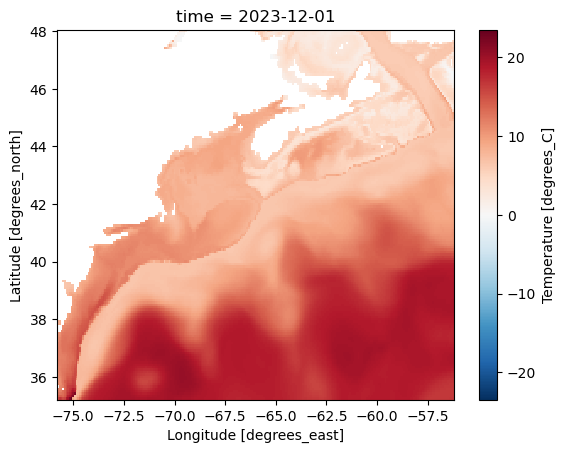

In [8]:
# Bottom first
# use kwargs to pull values for those indices
kwdepth = {'depth': glorys_bottom_idx}
var_array = glorys_all#['thetao']

# Now index the values out
dsSel = var_array.isel(**kwdepth)
ds = dsSel#.to_dataset()
ds.thetao.isel(time = -1).plot()

# Refocus/Reshape
bottom_ds = ds.rename_vars({
    "thetao" : "bottom_temp",
    "so" : "bottom_so"})
bottom_ds

Next, surface.

<xarray.Dataset> Size: 216MB
Dimensions:       (time: 372, latitude: 154, longitude: 235)
Coordinates:
    depth         (latitude, longitude) float32 145kB 0.494 0.494 ... 0.494
  * latitude      (latitude) float32 616B 35.25 35.33 35.42 ... 47.83 47.92 48.0
  * longitude     (longitude) float32 940B -75.75 -75.67 ... -56.33 -56.25
  * time          (time) datetime64[ns] 3kB 1993-01-01 1993-02-01 ... 2023-12-01
Data variables:
    surface_temp  (time, latitude, longitude) float64 108MB dask.array<chunksize=(84, 154, 235), meta=np.ndarray>
    surface_so    (time, latitude, longitude) float64 108MB dask.array<chunksize=(84, 154, 235), meta=np.ndarray>
Attributes: (12/15)
    Conventions:                   CF-1.6
    area:                          GLOBAL
    contact:                       servicedesk.cmems@mercator-ocean.eu
    credit:                        E.U. Copernicus Marine Service Information...
    dataset:                       global-reanalysis-001-030-monthly
    institution:                   Mercator Ocean
    ...                            ...
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    references:                    http://marine.copernicus.eu
    source:                        MERCATOR GLORYS12V1
    title:                         Monthly mean fields for product GLOBAL_REA...
    copernicusmarine_version:      1.3.1

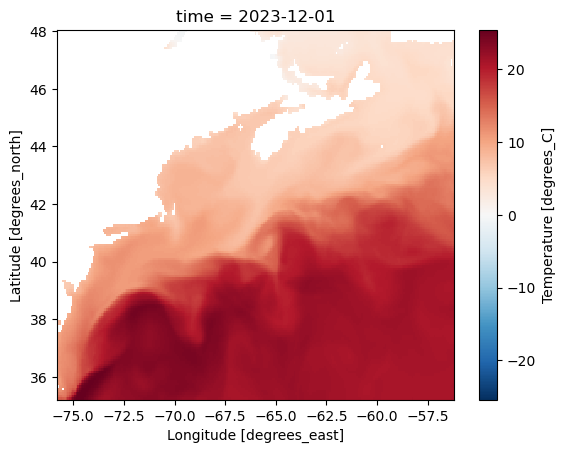

In [9]:
# use kwargs to pull values for those indices
kwdepth = {'depth': glorys_surface_idx}
var_array = glorys_all#['thetao']


# Now index the values out
dsSel = var_array.isel(**kwdepth)
ds = dsSel#.to_dataset()
ds.thetao.isel(time = -1).plot()

# Refocus/Reshape
surface_ds = ds.rename_vars({
    "thetao" : "surface_temp",
    "so"     : "surface_so"})
surface_ds

## Swap Depth from Coordinate to Variable

This step drops depth as a coordinate and changes it to a variable so people can see what the depth was used for "bottom" down the line. This keeps a record of what the depth was that we've taken values from.

In [10]:
# Drop the depth dimension where it exists, then rebuild.
# Takes the first layer for depth to grab surface measurements in the case of SST and bottom in the case where there
def depth_to_var(xr_ds, var, depth_var = "depth", t_coord = "time", x_coord = "longitude", y_coord = "latitude"):
    """Pull out data as an array, drop depth as a dimension, rebuild xr.array and add depth calues as a variable. 
    Need to pull surface measurement from surface data arrays so depth coordinate
    becomes unnecessary.
    
    Args:
        xr_ds      : xr.ArrayDataset
        var (str)  : String indicating variable to pull and process
    
    """
    
    # Pull the coordinates to keep
    time     = xr_ds.coords[t_coord]
    x_coords = xr_ds.coords[x_coord]
    y_coords = xr_ds.coords[y_coord]

    # Take the data values out as an array
    var_vals = xr_ds[var].values 
    depth_vals = xr_ds[depth_var].values

    # Rebuild an xr.array for the variable we're pulling out
    var_array = xr.DataArray(var_vals, coords = [time, y_coords, x_coords])

    # Another for depth
    depth_array = xr.DataArray(depth_vals, coords = [y_coords, x_coords])

    # Put them all together as one thing
    no_depth_ds = xr.Dataset({
        var  : var_array,
        "depth"  : depth_array})



    return no_depth_ds

In [11]:
# Do the reshaping for temperature
bottom_ds_new = depth_to_var(
    xr_ds = bottom_ds, 
    var = "bottom_temp", 
    depth_var = "depth", 
    t_coord = "time", 
    x_coord = "longitude", 
    y_coord = "latitude")
surface_ds_new = depth_to_var(
    xr_ds = surface_ds, 
    var = "surface_temp",
    depth_var = "depth", 
    t_coord = "time", 
    x_coord = "longitude", 
    y_coord = "latitude")

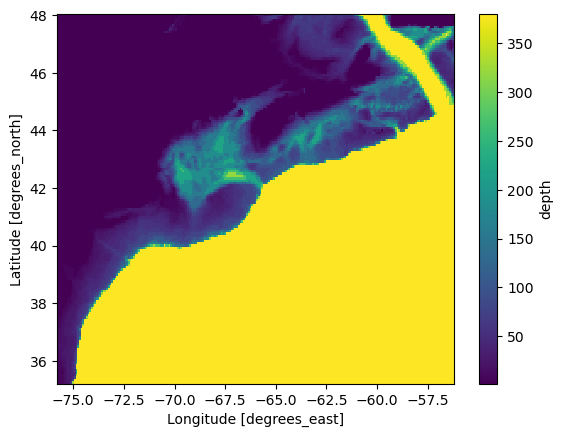

In [12]:
# Plot bottom 
bottom_ds_new.depth.plot()

# # Plot surface
# p2 = surface_ds_new.depth.plot()


# Save Bottom and Surface Temperature as Standalone Files

In [13]:
# I think we are just going to want to save out a single file and we also only need monthly averages
# These specific files were done by Andrew, and were not limited to 400m
# bottom_ds_new.to_netcdf(f"{box_path}RES_Data/GLORYs/NW_Atl_MonthlyTemps/BT.nc")
# surface_ds_new.to_netcdf(f"{box_path}RES_Data/GLORYs/NW_Atl_MonthlyTemps/SST.nc")

## Save them Together?

We definitely can save them as a file, but what to do with depth is kind of confusing. Would be worth saving it as an attribute at a minimum, to indicate what the max depth was allowed to be.

In [14]:
# glorys_all.attrs

In [16]:
bottom_temp = depth_to_var(
    xr_ds = bottom_ds, 
    var = "bottom_temp", 
    depth_var = "depth", 
    t_coord = "time", 
    x_coord = "longitude", 
    y_coord = "latitude")
surface_temp = depth_to_var(
    xr_ds = surface_ds, 
    var = "surface_temp",
    depth_var = "depth", 
    t_coord = "time", 
    x_coord = "longitude", 
    y_coord = "latitude")

surface_sal = depth_to_var(
    xr_ds = surface_ds, 
    var = "surface_so",
    depth_var = "depth", 
    t_coord = "time", 
    x_coord = "longitude", 
    y_coord = "latitude")

bottom_sal = depth_to_var(
    xr_ds = bottom_ds, 
    var = "bottom_so", 
    depth_var = "depth", 
    t_coord = "time", 
    x_coord = "longitude", 
    y_coord = "latitude")

new_ds = surface_temp
new_ds["bottom_temp"] = bottom_temp["bottom_temp"]
new_ds["surface_so"] = surface_sal["surface_so"]
new_ds["bottom_so"] = bottom_sal["bottom_so"]
new_ds = new_ds.drop_vars("depth")

# Borrowing attributes from GLORYS
new_ds.attrs = {
    #'Conventions': 'CF-1.6',
    'area': 'Northwest Atlantic',
    'contact': 'akemberling@gmri.org',
    'credit': 'E.U. Copernicus Marine Service Information (CMEMS)',
    'dataset': 'global-reanalysis-001-030-monthly',
    'institution': 'Mercator Ocean & Gulf of Maine Research Institute',
    'licence': 'http://marine.copernicus.eu/services-portfolio/service-commitments-and-licence/',
    'producer': 'CMEMS - Global Monitoring and Forecasting Centre',
    'product': 'GLOBAL_REANALYSIS_001_030',
    'product_user_manual': 'http://marine.copernicus.eu/documents/PUM/CMEMS-GLO-PUM-001-030.pdf',
    'quality_information_document': 'http://marine.copernicus.eu/documents/QUID/CMEMS-GLO-QUID-001-030.pdf',
    'references': 'http://marine.copernicus.eu',
    'source': 'MERCATOR GLORYS12V1',
    'title': 'Monthly mean fields for product GLOBAL_REANALYSIS_PHY_001_030',
    'copernicusmarine_version': '1.3.1',
    'modifications' : 'Stripped surface layers and bottom layer to max depth of'}

# Save it
new_ds.to_netcdf(f"{box_path}RES_Data/GLORYs/NW_Atl_MonthlyTemps/Surface_Bottom_Monthly_TempSal_to_400m.nc")


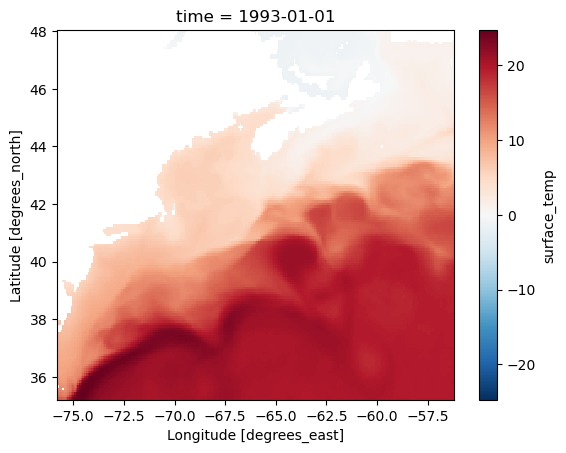

In [17]:
new_ds.surface_temp.isel(time = 0).plot()

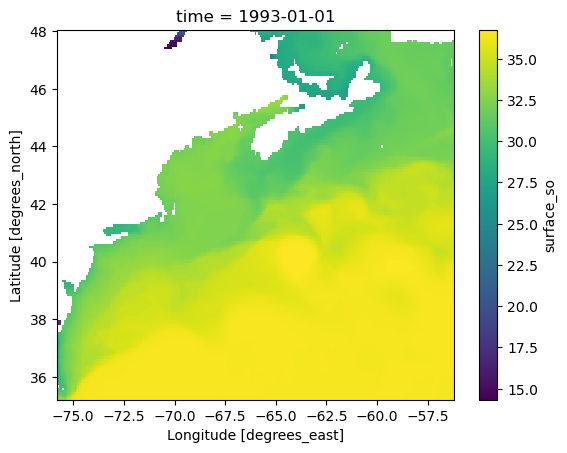

In [18]:
new_ds.surface_so.isel(time = 0).plot()

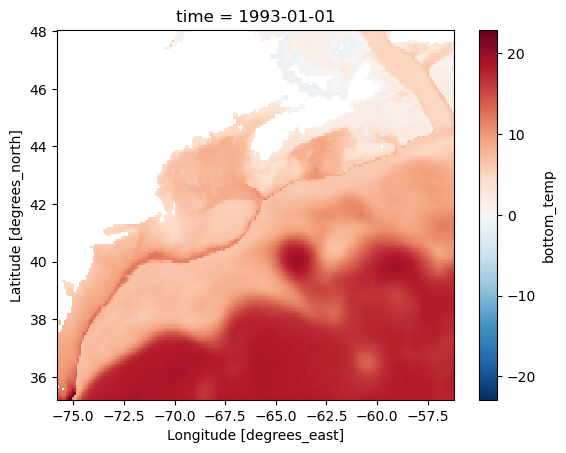

In [19]:
new_ds.bottom_temp.isel(time = 0).plot()

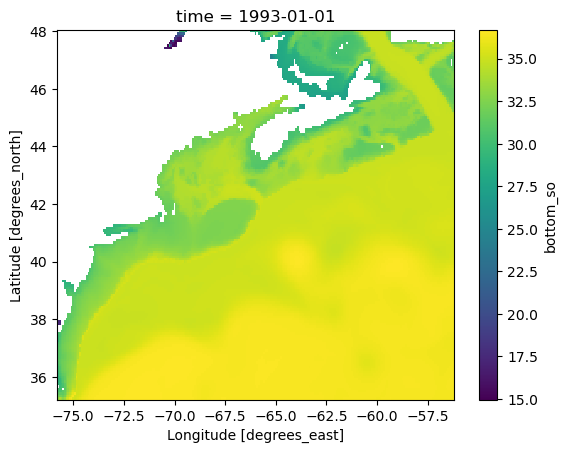

In [20]:
new_ds.bottom_so.isel(time = 0).plot()